# Нейросетевые методы обработки и оценки качества медиаданных &mdash; Image deblurring task

<img src="images/blur.png">

In the first task of the course you will have to implement an image deblurring method.  
We will start with the simplest possible network and by the end of the task you will implement SOTA deblurring architecture.

## Preliminaries

In [1]:
!cp /kaggle/input/mediann-1/utils.py utils.py
!cp /kaggle/input/mediann-1/GoPro/GoPro GoPro -r

In [1]:
from utils import download_from_yadisk, test_model
import os

TARGET_DIR = '.'
FILENAME = "GoPro.zip"

if not os.path.exists(os.path.join(TARGET_DIR, FILENAME)):
    # we are going to download 5.2 gb file, downloading will take some time
    download_from_yadisk(
        short_url='https://disk.yandex.ru/d/v7O5TOsstnsscw',
        filename=FILENAME,
        target_dir=TARGET_DIR
    )

In [2]:
!unzip -qq GoPro.zip

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid

from torchvision import transforms
from PIL import Image
import os

print(f"GPU: {torch.cuda.is_available()}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

GPU: True


### Prepare Dataset

In [5]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pathlib import Path

class GoProDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        blur_path = Path(f"{root_dir}/blur")
        sharp_path = Path(f"{root_dir}/sharp")
        self.blurry_images = [p.name for p in list(blur_path.glob("*.png"))]

    def __len__(self):
        return len(self.blurry_images)

    def __getitem__(self, idx):
        blurry_path = Path(self.root_dir, 'blur', self.blurry_images[idx])
        sharp_path = Path(self.root_dir, 'sharp', self.blurry_images[idx]) 

        blurry_image = np.array(Image.open(blurry_path).convert('RGB'))
        sharp_image = np.array(Image.open(sharp_path).convert('RGB'))

        if self.transform:
            blurry_image = blurry_image.astype(np.float32)/255.0
            sharp_image = sharp_image.astype(np.float32)/255.0
            augmented = self.transform(image=blurry_image, image1=sharp_image)
            blurry_image = augmented['image']
            blurry_image = blurry_image.to(torch.float32)
            sharp_image = augmented['image1']
            sharp_image = sharp_image.to(torch.float32)

        return blurry_image, sharp_image

transform = A.Compose([
    A.RandomCrop(256, 256, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5), 
    ToTensorV2(),
], additional_targets={
        'image1': 'image'}, p=1)

transform_test = A.Compose([
    ToTensorV2(),
], additional_targets={
        'image1': 'image'}, p=1)

train_dataset = GoProDataset(root_dir='GoPro/train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=16)

test_dataset = GoProDataset(root_dir='GoPro/test', transform=transform_test)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

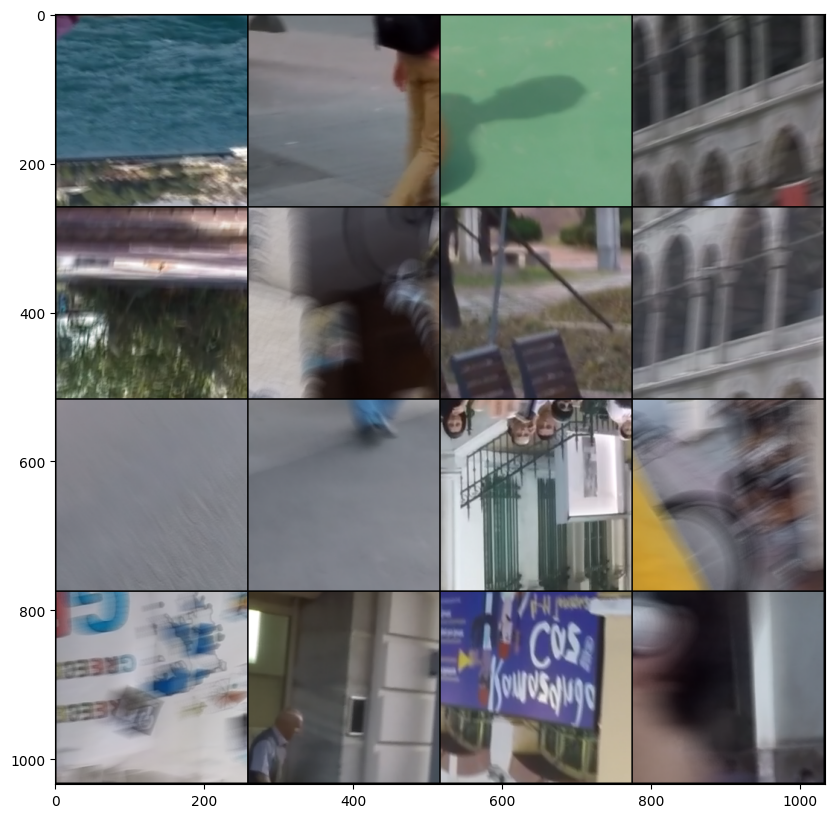

In [6]:
samples = torch.stack([train_dataset[i][0] for i in range(32, 48)], dim=0)

plt.figure(figsize=(10, 10))
plt.imshow(make_grid(samples, nrow=4).permute(1, 2, 0))
plt.show()

## Baseline

### Basic network (1 point)
We will start off by implementing the simplest possible convolutional neural network.  
A few convolutional layers, without pooling.

Remenicent of early works in [Super-Resolution](https://arxiv.org/abs/1501.00092) and [Denoising](https://arxiv.org/abs/1608.03981)

**Important to note that our network will learn the residual for debluring**  
$I_{deblur}=I_{input} + f_{\theta}(I_{input})$

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvBnBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """Simple convolutional block

        Your task is to fill in the following modules:

            conv + bn + relu
        
        """
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        
        return self.relu(self.bn(self.conv(x)))


class Baseline(nn.Module):
    def __init__(self, block, n_blocks=5, n_filters=64):
        """Basic convolutional model
        
        Your task is to implement the following architecture:

            input_conv(3, n_filters)
            n_blocks * ConvBnBlock
            output_conv(n_filters, 3)
        
        """

        super().__init__()
        self.input_conv = nn.Conv2d(3, n_filters, kernel_size=3, padding=1)
        self.blocks = nn.ModuleList([block(n_filters, n_filters) for _ in range(n_blocks)])
        self.output_conv = nn.Conv2d(n_filters, 3, kernel_size=3, padding=1)
        
    def forward(self, x):
        inp = x
        x = self.input_conv(x)
        for block in self.blocks:
            x = block(x)
        x = self.output_conv(x)
        return x + inp

In [8]:
baseline = Baseline(ConvBnBlock)
test_input = torch.rand(1, 3, 256, 256)
test_output = baseline(test_input)
assert test_input.shape == test_output.shape

### PSNR Loss (0.5 points)

We will directly optimize the PSNR quality metric instead of plain MSE  
$PSNR = 10 * \log_{10}(\frac{MAX_I^2}{MSE})$  
In out case the images are normed to [0, 1], so the $MAX_I=1$

Be careful when averaging, first calculate the MSE for each pair of images, only then apply log and after that average along batch axis. 

In [8]:
class PSNRLoss(nn.Module):
    def __init__(self):
        """Peak signal-to-noise ratio loss function
        
        NOTE: during training we minimize the loss but greater PSNR mean better
        So you may carry the -1 into the log when implementing
        thus elimating the need for division
        """
        super().__init__()
        self.eps = 1e-8  # use eps to prevent 0 in log

    def forward(self, pred, target):
        """
            Implement the following calculation:

                10 * mean(log10(mse(pred, target)))

        """
        mse = ((pred - target) ** 2).mean((1, 2, 3))
        return -10 * torch.log10(1 / mse + self.eps).mean()

In [9]:
criterion = PSNRLoss()
a = torch.tensor([[[[0.1632, 0.0024, 0.9913, 0.8892],
          [0.5655, 0.4472, 0.4592, 0.2013],
          [0.7722, 0.9089, 0.1708, 0.3654],
          [0.6147, 0.9567, 0.7018, 0.2376]]]])
b = torch.tensor([[[[0.8498, 0.1168, 0.3987, 0.6781],
          [0.7864, 0.9762, 0.3694, 0.9926],
          [0.9000, 0.0293, 0.0454, 0.0984],
          [0.9478, 0.3730, 0.9617, 0.5052]]]])
assert torch.isclose(criterion(a, b), torch.tensor(-6.8417))

### Training (0.5 points)
Basic training pipeline.

Note the use of gradient clipping, while not required to train the simplest model it will greately help for later parts of the task!

Hint: use [`torch.nn.utils.clip_grad_norm_`](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html), `max_norm=0.05` worked fine

In [10]:
from tqdm import tqdm


def train_model(model, train_dataloader, optimizer, criterion, scheduler, num_epochs=200, checkpoints_path="./checkpoints", use_grad_clip=True):
    # Create checkpoints folder
    PATH = checkpoints_path
    SAVE_EPOCH = 5
    os.makedirs(PATH, exist_ok = True)
    
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for inputs, targets in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))

            if use_grad_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.05)
            
            loss.backward()
            optimizer.step()
    
        if epoch % SAVE_EPOCH == 0:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()
                    }, os.path.join(PATH, f"epoch_{epoch+1}.tar"))
    
        # Update the learning rate
        scheduler.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, LR: {scheduler.get_last_lr()[0]}')

In [18]:
from utils import get_scheduler

torch.manual_seed(11)

model = Baseline(ConvBnBlock)
model = model.to(device)

criterion = PSNRLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
use_grad_clip = True
scheduler = get_scheduler(optimizer)

train_model(model, train_dataloader, optimizer, criterion, scheduler, num_epochs=35)

  3%|▎         | 1/35 [01:02<35:33, 62.74s/it]

Epoch 1, Loss: -24.62166976928711, LR: 0.000975530705321762


  6%|▌         | 2/35 [02:06<34:46, 63.23s/it]

Epoch 2, Loss: -28.166255950927734, LR: 0.0009045180463377549


  9%|▊         | 3/35 [03:09<33:49, 63.43s/it]

Epoch 3, Loss: -27.448307037353516, LR: 0.0007939132368836219


 11%|█▏        | 4/35 [04:12<32:40, 63.24s/it]

Epoch 4, Loss: -27.621517181396484, LR: 0.0006545430463377549


 14%|█▍        | 5/35 [05:15<31:31, 63.06s/it]

Epoch 5, Loss: -27.062416076660156, LR: 0.0005000499999999999


 17%|█▋        | 6/35 [06:18<30:29, 63.09s/it]

Epoch 6, Loss: -20.41425323486328, LR: 0.00034555695366224505


 20%|██        | 7/35 [07:21<29:22, 62.96s/it]

Epoch 7, Loss: -33.28119659423828, LR: 0.0002061867631163781


 23%|██▎       | 8/35 [08:24<28:18, 62.90s/it]

Epoch 8, Loss: -22.635055541992188, LR: 9.558195366224507e-05


 26%|██▌       | 9/35 [09:27<27:15, 62.90s/it]

Epoch 9, Loss: -30.941734313964844, LR: 2.456929467823799e-05


 29%|██▊       | 10/35 [10:30<26:11, 62.87s/it]

Epoch 10, Loss: -24.333633422851562, LR: 1e-07


 31%|███▏      | 11/35 [11:32<25:06, 62.76s/it]

Epoch 11, Loss: -28.342529296875, LR: 0.000487815352660881


 34%|███▍      | 12/35 [12:35<24:04, 62.79s/it]

Epoch 12, Loss: -26.956193923950195, LR: 0.0004523090231688775


 37%|███▋      | 13/35 [13:38<23:01, 62.79s/it]

Epoch 13, Loss: -29.54595184326172, LR: 0.000397006618441811


 40%|████      | 14/35 [14:40<21:56, 62.71s/it]

Epoch 14, Loss: -27.212942123413086, LR: 0.00032732152316887746


 43%|████▎     | 15/35 [15:43<20:56, 62.81s/it]

Epoch 15, Loss: -31.382844924926758, LR: 0.000250075


 46%|████▌     | 16/35 [16:46<19:52, 62.78s/it]

Epoch 16, Loss: -22.60709571838379, LR: 0.00017282847683112253


 49%|████▊     | 17/35 [17:49<18:49, 62.75s/it]

Epoch 17, Loss: -28.683509826660156, LR: 0.00010314338155818905


 51%|█████▏    | 18/35 [18:51<17:46, 62.73s/it]

Epoch 18, Loss: -30.318923950195312, LR: 4.784097683112254e-05


 54%|█████▍    | 19/35 [19:54<16:42, 62.65s/it]

Epoch 19, Loss: -31.147247314453125, LR: 1.2334647339118996e-05


 57%|█████▋    | 20/35 [20:56<15:39, 62.64s/it]

Epoch 20, Loss: -24.77412223815918, LR: 1e-07


 60%|██████    | 21/35 [21:59<14:38, 62.73s/it]

Epoch 21, Loss: -29.50819969177246, LR: 0.000487815352660881


 63%|██████▎   | 22/35 [23:02<13:35, 62.74s/it]

Epoch 22, Loss: -33.494598388671875, LR: 0.0004523090231688775


 66%|██████▌   | 23/35 [24:05<12:33, 62.75s/it]

Epoch 23, Loss: -23.978071212768555, LR: 0.000397006618441811


 69%|██████▊   | 24/35 [25:07<11:29, 62.68s/it]

Epoch 24, Loss: -28.357999801635742, LR: 0.00032732152316887746


 71%|███████▏  | 25/35 [26:10<10:27, 62.70s/it]

Epoch 25, Loss: -24.344682693481445, LR: 0.000250075


 74%|███████▍  | 26/35 [27:13<09:24, 62.74s/it]

Epoch 26, Loss: -21.614364624023438, LR: 0.00017282847683112253


 77%|███████▋  | 27/35 [28:16<08:22, 62.83s/it]

Epoch 27, Loss: -24.108400344848633, LR: 0.00010314338155818905


 80%|████████  | 28/35 [29:19<07:19, 62.81s/it]

Epoch 28, Loss: -21.14733123779297, LR: 4.784097683112254e-05


 83%|████████▎ | 29/35 [30:21<06:15, 62.64s/it]

Epoch 29, Loss: -28.853988647460938, LR: 1.2334647339118996e-05


 86%|████████▌ | 30/35 [31:23<05:12, 62.54s/it]

Epoch 30, Loss: -27.62078094482422, LR: 1e-07


 89%|████████▊ | 31/35 [32:26<04:09, 62.49s/it]

Epoch 31, Loss: -29.735782623291016, LR: 0.000487815352660881


 91%|█████████▏| 32/35 [33:28<03:07, 62.50s/it]

Epoch 32, Loss: -21.823110580444336, LR: 0.0004523090231688775


 94%|█████████▍| 33/35 [34:31<02:05, 62.57s/it]

Epoch 33, Loss: -24.940963745117188, LR: 0.000397006618441811


 97%|█████████▋| 34/35 [35:34<01:02, 62.62s/it]

Epoch 34, Loss: -26.330678939819336, LR: 0.00032732152316887746


100%|██████████| 35/35 [36:36<00:00, 62.76s/it]

Epoch 35, Loss: -22.99872398376465, LR: 0.000250075


In [21]:
result = test_model(model, device, test_dataloader)
assert result <= 0.00252
print("Congrats!")

100%|██████████| 634/634 [02:06<00:00,  5.00it/s]

Mean MSE: 0.002398112520344217
Congrats!


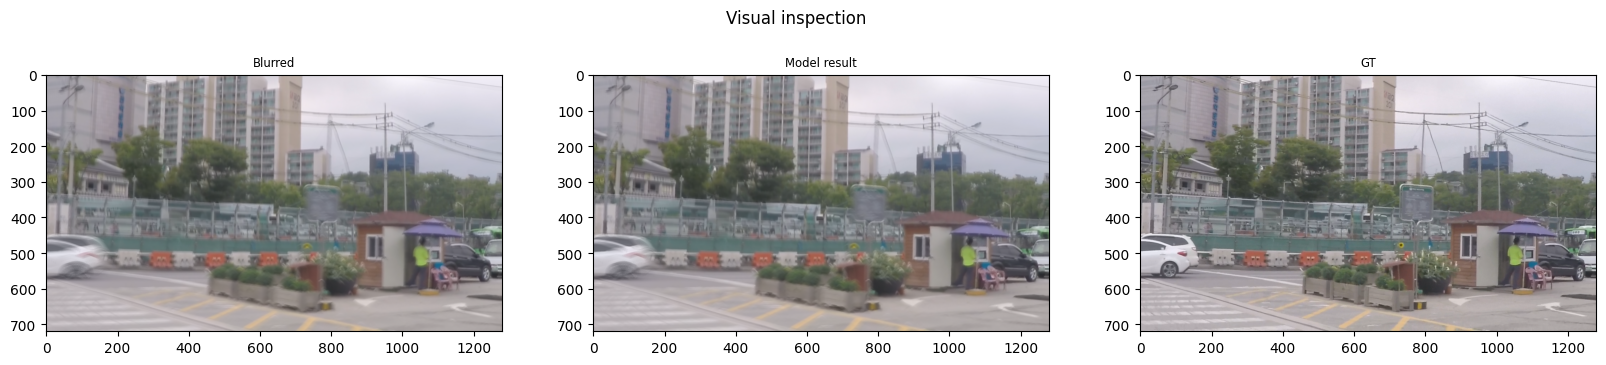

In [22]:
pics = test_dataset[2]
blurred, gt = pics[0], pics[1]
plt.figure(figsize=(20, 4))
plt.suptitle("Visual inspection")
plt.subplot(131)
plt.title("Blurred")
plt.imshow(blurred.permute(1, 2, 0))
plt.subplot(132)
plt.title("Model result")
with torch.no_grad():
    output = model(blurred.unsqueeze(0).to(device)).cpu().squeeze(0).permute(1, 2, 0).numpy()
output = np.clip(output, 0, 1)
plt.imshow(output)
plt.subplot(133)
plt.imshow(gt.permute(1, 2, 0))
plt.title("GT")
plt.show()

## UNet

The next step is to process our image in multiple scales, like the multi-scale methods of old school CV.

The most common model that uses multiple scales is the [UNet](https://arxiv.org/abs/1505.04597), first proposed for medical segmentation and containing many strange design decisions.  
Nonetheless, it has proven to be useful for many CV tasks and is videly used in image and video restoration.

U-Nets are named as such because they have this U-like shape, where the input image is first reduced in dimensionality in the downsizing portion, then increased in dimensionality back to its original size in the upsizing portion.

<img src="images/unet.png">


UNet may be implemented with either concatenation of skip-connections or with the summation.  
The results usually do not differ that much.

### Double convolution (0.5 points)
In UNet each convolution block is created with two convolutions.  
You have to implement a simple stack of two layers of convolution with two ReLU activations

In [11]:
class UNetBlock(nn.Module):
    def __init__(self, in_channels):
        """Basic building block of UNet architecture
        
        Your task is to fill in the following modules:

            conv + bn + relu + conv + bn + relu
            
        """
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

In [25]:
block = UNetBlock(64)
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 64, 256, 256])

### UNet Down block (0.5 points)

In [12]:
class UNetDownBlock(nn.Module):
    def __init__(self, chan):
        """Downsampling block in the encoder of UNet

            Your task is to fill in the following modules:
            
                AvgPool + Conv 1x1

            Input spatial dimension is **reduced** by a factor of 2  
            The number of channels is **increased** by a factor of 2
        """
        super().__init__()
        self.pool = nn.AvgPool2d(2)
        self.conv = nn.Conv2d(chan, chan * 2, kernel_size=1)
    
    def forward(self, x):
        return self.conv(self.pool(x))

In [29]:
block = UNetDownBlock(64)
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 128, 128, 128])

### UNet Up block (0.5 points)

In [13]:
class UNetUpBlock(nn.Module):
    def __init__(self, chan):
        """Upsampling block in the encoder of UNet

            Your task is to fill in the following modules:
            
                Upsample + Conv2d

            Input spatial dimension is **increased** by a factor of 2  
            The number of channels is **reduced** by a factor of 2
        """
        super(UNetUpBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv = nn.Conv2d(chan, chan // 2, kernel_size=1)

    def forward(self, x):
        return self.conv(self.upsample(x))

In [31]:
block = UNetUpBlock(64)
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 32, 512, 512])

### Generalized Unet arch (1.5 points)
Over the years the UNet architecture has proven itself useful.  
Many follow up papers retain macro level architecture and change individual blocks, i.e. only changing the downscaling operation, changing number of convs in block, adding attention to bottleneck, etc.  

Therefore we will also implement a generalized architecture.

**Your model must pass the quality assert to get points for this part**

In [14]:
class GeneralizedUNet(nn.Module):
    def __init__(self, block, downBlock, upBlock, img_channel=3, width=16, 
                 middle_blk_num=1, enc_blk_nums=[1,1,1,1], dec_blk_nums=[1,1,1,1]):
        """GeneralizedUNet architecture
        
            This part is implemented for you
            But feel free to change it

        """
        super().__init__()

        self.intro = nn.Conv2d(in_channels=img_channel, out_channels=width, kernel_size=3, padding=1, stride=1, groups=1, bias=True)
        self.ending = nn.Conv2d(in_channels=width, out_channels=img_channel, kernel_size=3, padding=1, stride=1, groups=1, bias=True)

        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.middle_blks = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()

        chan = width
        
        for num in enc_blk_nums:
            self.encoders.append(
                nn.Sequential(
                    *[block(chan) for _ in range(num)]
                )
            )
            self.downs.append(
                downBlock(chan)
            )
            chan = chan * 2

        self.middle_blks = \
            nn.Sequential(
                *[block(chan) for _ in range(middle_blk_num)]
            )
        
        for num in dec_blk_nums:
            self.ups.append(
                upBlock(chan)
            )
            chan = chan // 2
            self.decoders.append(
                nn.Sequential(
                    *[block(chan) for _ in range(num)]
                )
            )

        self.padder_size = 2 ** len(self.encoders)

    def forward(self, inp):
        """Performs forward pass of a UNet-like model

        Your task is to implement the following steps:

            1. Intro convolution
            2. Encoder blocks + save skip connections + downsample
            3. Middle blocks (also known as bottleneck)
            4. Decoder blocks + add skip connection
            5. Ending
            6. Inp + ending out (we're still using residual lerning)

        """
        activations = []
        x = self.intro(inp)
        for i in range(len(self.encoders)):
            x = self.encoders[i](x)
            activations.append(x)
            x = self.downs[i](x)
        x = self.middle_blks(x)
        for i in range(len(self.decoders)):
            x = self.ups[i](x)
            x = self.decoders[i](x)
            x = x + activations[- (i + 1)]
        x = self.ending(x)
        return x + inp

In [35]:
model = GeneralizedUNet(UNetBlock, UNetDownBlock, UNetUpBlock)
vec = torch.rand(16, 3, 256, 256)
assert model(vec).shape == torch.Size([16, 3, 256, 256])

### Train UNet

In [36]:
torch.manual_seed(11)

model = GeneralizedUNet(UNetBlock, UNetDownBlock, UNetUpBlock)
model = model.to(device)

criterion = PSNRLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
use_grad_clip = True
scheduler = get_scheduler(optimizer)

train_model(model, train_dataloader, optimizer, criterion, scheduler, num_epochs=100, use_grad_clip=use_grad_clip)

  1%|          | 1/100 [01:03<1:45:28, 63.92s/it]

Epoch 1, Loss: -32.39606475830078, LR: 0.000975530705321762


  2%|▏         | 2/100 [02:07<1:44:06, 63.74s/it]

Epoch 2, Loss: -24.3895320892334, LR: 0.0009045180463377549


  3%|▎         | 3/100 [03:10<1:42:47, 63.59s/it]

Epoch 3, Loss: -27.383689880371094, LR: 0.0007939132368836219


  4%|▍         | 4/100 [04:14<1:41:36, 63.50s/it]

Epoch 4, Loss: -26.250030517578125, LR: 0.0006545430463377549


  5%|▌         | 5/100 [05:17<1:40:37, 63.56s/it]

Epoch 5, Loss: -25.263986587524414, LR: 0.0005000499999999999


  6%|▌         | 6/100 [06:21<1:39:36, 63.58s/it]

Epoch 6, Loss: -23.24610137939453, LR: 0.00034555695366224505


  7%|▋         | 7/100 [07:25<1:38:32, 63.58s/it]

Epoch 7, Loss: -27.520793914794922, LR: 0.0002061867631163781


  8%|▊         | 8/100 [08:28<1:37:27, 63.56s/it]

Epoch 8, Loss: -21.536754608154297, LR: 9.558195366224507e-05


  9%|▉         | 9/100 [09:32<1:36:27, 63.60s/it]

Epoch 9, Loss: -24.995115280151367, LR: 2.456929467823799e-05


 10%|█         | 10/100 [10:36<1:35:25, 63.62s/it]

Epoch 10, Loss: -24.844615936279297, LR: 1e-07


 11%|█         | 11/100 [11:39<1:34:30, 63.71s/it]

Epoch 11, Loss: -29.340789794921875, LR: 0.000487815352660881


 12%|█▏        | 12/100 [12:43<1:33:30, 63.76s/it]

Epoch 12, Loss: -27.850833892822266, LR: 0.0004523090231688775


 13%|█▎        | 13/100 [13:47<1:32:19, 63.67s/it]

Epoch 13, Loss: -25.405345916748047, LR: 0.000397006618441811


 14%|█▍        | 14/100 [14:50<1:31:15, 63.67s/it]

Epoch 14, Loss: -26.0322265625, LR: 0.00032732152316887746


 15%|█▌        | 15/100 [15:54<1:30:07, 63.62s/it]

Epoch 15, Loss: -32.13895797729492, LR: 0.000250075


 16%|█▌        | 16/100 [16:57<1:29:01, 63.59s/it]

Epoch 16, Loss: -24.91561508178711, LR: 0.00017282847683112253


 17%|█▋        | 17/100 [18:01<1:28:00, 63.62s/it]

Epoch 17, Loss: -30.427274703979492, LR: 0.00010314338155818905


 18%|█▊        | 18/100 [19:05<1:26:55, 63.60s/it]

Epoch 18, Loss: -22.918411254882812, LR: 4.784097683112254e-05


 19%|█▉        | 19/100 [20:08<1:25:54, 63.64s/it]

Epoch 19, Loss: -29.538894653320312, LR: 1.2334647339118996e-05


 20%|██        | 20/100 [21:12<1:24:43, 63.55s/it]

Epoch 20, Loss: -31.808570861816406, LR: 1e-07


 21%|██        | 21/100 [22:15<1:23:41, 63.56s/it]

Epoch 21, Loss: -31.128215789794922, LR: 0.000487815352660881


 22%|██▏       | 22/100 [23:19<1:22:35, 63.54s/it]

Epoch 22, Loss: -26.658382415771484, LR: 0.0004523090231688775


 23%|██▎       | 23/100 [24:22<1:21:30, 63.51s/it]

Epoch 23, Loss: -26.247631072998047, LR: 0.000397006618441811


 24%|██▍       | 24/100 [25:26<1:20:26, 63.51s/it]

Epoch 24, Loss: -29.05008316040039, LR: 0.00032732152316887746


 25%|██▌       | 25/100 [26:29<1:19:20, 63.48s/it]

Epoch 25, Loss: -32.20583724975586, LR: 0.000250075


 26%|██▌       | 26/100 [27:33<1:18:16, 63.47s/it]

Epoch 26, Loss: -29.186418533325195, LR: 0.00017282847683112253


 27%|██▋       | 27/100 [28:36<1:17:13, 63.47s/it]

Epoch 27, Loss: -25.056533813476562, LR: 0.00010314338155818905


 28%|██▊       | 28/100 [29:39<1:16:07, 63.44s/it]

Epoch 28, Loss: -27.597835540771484, LR: 4.784097683112254e-05


 29%|██▉       | 29/100 [30:43<1:15:03, 63.42s/it]

Epoch 29, Loss: -22.76816177368164, LR: 1.2334647339118996e-05


 30%|███       | 30/100 [31:46<1:13:58, 63.41s/it]

Epoch 30, Loss: -25.106082916259766, LR: 1e-07


 31%|███       | 31/100 [32:50<1:12:54, 63.40s/it]

Epoch 31, Loss: -25.811376571655273, LR: 0.000487815352660881


 32%|███▏      | 32/100 [33:53<1:11:53, 63.44s/it]

Epoch 32, Loss: -27.51495361328125, LR: 0.0004523090231688775


 33%|███▎      | 33/100 [34:56<1:10:47, 63.40s/it]

Epoch 33, Loss: -27.027482986450195, LR: 0.000397006618441811


 34%|███▍      | 34/100 [36:00<1:09:44, 63.40s/it]

Epoch 34, Loss: -23.479795455932617, LR: 0.00032732152316887746


 35%|███▌      | 35/100 [37:03<1:08:39, 63.37s/it]

Epoch 35, Loss: -34.655311584472656, LR: 0.000250075


 36%|███▌      | 36/100 [38:07<1:07:41, 63.47s/it]

Epoch 36, Loss: -22.2996826171875, LR: 0.00017282847683112253


 37%|███▋      | 37/100 [39:10<1:06:40, 63.50s/it]

Epoch 37, Loss: -22.648380279541016, LR: 0.00010314338155818905


 38%|███▊      | 38/100 [40:14<1:05:42, 63.60s/it]

Epoch 38, Loss: -28.974403381347656, LR: 4.784097683112254e-05


 39%|███▉      | 39/100 [41:18<1:04:40, 63.62s/it]

Epoch 39, Loss: -26.798973083496094, LR: 1.2334647339118996e-05


 40%|████      | 40/100 [42:21<1:03:35, 63.59s/it]

Epoch 40, Loss: -27.829980850219727, LR: 1e-07


 41%|████      | 41/100 [43:25<1:02:31, 63.58s/it]

Epoch 41, Loss: -30.68090057373047, LR: 0.000487815352660881


 42%|████▏     | 42/100 [44:29<1:01:26, 63.57s/it]

Epoch 42, Loss: -25.254438400268555, LR: 0.0004523090231688775


 43%|████▎     | 43/100 [45:32<1:00:22, 63.56s/it]

Epoch 43, Loss: -28.22159194946289, LR: 0.000397006618441811


 44%|████▍     | 44/100 [46:36<59:18, 63.54s/it]  

Epoch 44, Loss: -24.229631423950195, LR: 0.00032732152316887746


 45%|████▌     | 45/100 [47:39<58:12, 63.50s/it]

Epoch 45, Loss: -25.105819702148438, LR: 0.000250075


 46%|████▌     | 46/100 [48:42<57:09, 63.50s/it]

Epoch 46, Loss: -25.652240753173828, LR: 0.00017282847683112253


 47%|████▋     | 47/100 [49:46<56:05, 63.50s/it]

Epoch 47, Loss: -23.02334213256836, LR: 0.00010314338155818905


 48%|████▊     | 48/100 [50:50<55:02, 63.51s/it]

Epoch 48, Loss: -24.791790008544922, LR: 4.784097683112254e-05


 49%|████▉     | 49/100 [51:53<53:57, 63.47s/it]

Epoch 49, Loss: -25.927936553955078, LR: 1.2334647339118996e-05


 50%|█████     | 50/100 [52:56<52:53, 63.47s/it]

Epoch 50, Loss: -20.241458892822266, LR: 1e-07


 51%|█████     | 51/100 [54:00<51:52, 63.51s/it]

Epoch 51, Loss: -25.454387664794922, LR: 0.00029272921159652864


 52%|█████▏    | 52/100 [55:04<50:49, 63.53s/it]

Epoch 52, Loss: -28.68981170654297, LR: 0.0002714254139013265


 53%|█████▎    | 53/100 [56:07<49:45, 63.51s/it]

Epoch 53, Loss: -28.006683349609375, LR: 0.00023824397106508657


 54%|█████▍    | 54/100 [57:10<48:39, 63.47s/it]

Epoch 54, Loss: -27.51892852783203, LR: 0.0001964329139013265


 55%|█████▌    | 55/100 [58:14<47:33, 63.42s/it]

Epoch 55, Loss: -25.545921325683594, LR: 0.000150085


 56%|█████▌    | 56/100 [59:17<46:30, 63.43s/it]

Epoch 56, Loss: -24.587688446044922, LR: 0.00010373708609867352


 57%|█████▋    | 57/100 [1:00:21<45:29, 63.48s/it]

Epoch 57, Loss: -27.710674285888672, LR: 6.192602893491343e-05


 58%|█████▊    | 58/100 [1:01:24<44:26, 63.50s/it]

Epoch 58, Loss: -34.68063735961914, LR: 2.8744586098673522e-05


 59%|█████▉    | 59/100 [1:02:28<43:21, 63.46s/it]

Epoch 59, Loss: -29.19849395751953, LR: 7.440788403471397e-06


 60%|██████    | 60/100 [1:03:31<42:19, 63.49s/it]

Epoch 60, Loss: -27.2689151763916, LR: 1e-07


 61%|██████    | 61/100 [1:04:35<41:16, 63.50s/it]

Epoch 61, Loss: -27.503488540649414, LR: 0.00029272921159652864


 62%|██████▏   | 62/100 [1:05:38<40:10, 63.43s/it]

Epoch 62, Loss: -28.890419006347656, LR: 0.0002714254139013265


 63%|██████▎   | 63/100 [1:06:41<39:05, 63.40s/it]

Epoch 63, Loss: -25.429481506347656, LR: 0.00023824397106508657


 64%|██████▍   | 64/100 [1:07:45<38:02, 63.40s/it]

Epoch 64, Loss: -23.1973876953125, LR: 0.0001964329139013265


 65%|██████▌   | 65/100 [1:08:48<36:58, 63.40s/it]

Epoch 65, Loss: -26.41311264038086, LR: 0.000150085


 66%|██████▌   | 66/100 [1:09:52<35:57, 63.45s/it]

Epoch 66, Loss: -30.40530014038086, LR: 0.00010373708609867352


 67%|██████▋   | 67/100 [1:10:55<34:54, 63.47s/it]

Epoch 67, Loss: -30.819616317749023, LR: 6.192602893491343e-05


 68%|██████▊   | 68/100 [1:11:59<33:50, 63.46s/it]

Epoch 68, Loss: -29.76769256591797, LR: 2.8744586098673522e-05


 69%|██████▉   | 69/100 [1:13:02<32:46, 63.42s/it]

Epoch 69, Loss: -29.1866455078125, LR: 7.440788403471397e-06


 70%|███████   | 70/100 [1:14:05<31:41, 63.38s/it]

Epoch 70, Loss: -28.639476776123047, LR: 1e-07


 71%|███████   | 71/100 [1:15:09<30:39, 63.43s/it]

Epoch 71, Loss: -26.510000228881836, LR: 0.00029272921159652864


 72%|███████▏  | 72/100 [1:16:12<29:35, 63.42s/it]

Epoch 72, Loss: -27.269245147705078, LR: 0.0002714254139013265


 73%|███████▎  | 73/100 [1:17:16<28:32, 63.42s/it]

Epoch 73, Loss: -27.523324966430664, LR: 0.00023824397106508657


 74%|███████▍  | 74/100 [1:18:19<27:29, 63.42s/it]

Epoch 74, Loss: -28.443450927734375, LR: 0.0001964329139013265


 75%|███████▌  | 75/100 [1:19:23<26:26, 63.45s/it]

Epoch 75, Loss: -28.626964569091797, LR: 0.000150085


 76%|███████▌  | 76/100 [1:20:26<25:23, 63.46s/it]

Epoch 76, Loss: -27.822969436645508, LR: 0.00010373708609867352


 77%|███████▋  | 77/100 [1:21:29<24:19, 63.45s/it]

Epoch 77, Loss: -27.541349411010742, LR: 6.192602893491343e-05


 78%|███████▊  | 78/100 [1:22:33<23:15, 63.43s/it]

Epoch 78, Loss: -26.4829158782959, LR: 2.8744586098673522e-05


 79%|███████▉  | 79/100 [1:23:36<22:12, 63.45s/it]

Epoch 79, Loss: -26.50762176513672, LR: 7.440788403471397e-06


 80%|████████  | 80/100 [1:24:40<21:09, 63.47s/it]

Epoch 80, Loss: -27.482707977294922, LR: 1e-07


 81%|████████  | 81/100 [1:25:43<20:05, 63.45s/it]

Epoch 81, Loss: -28.07267951965332, LR: 0.00029272921159652864


 82%|████████▏ | 82/100 [1:26:47<19:01, 63.43s/it]

Epoch 82, Loss: -27.606868743896484, LR: 0.0002714254139013265


 83%|████████▎ | 83/100 [1:27:50<17:57, 63.40s/it]

Epoch 83, Loss: -26.633453369140625, LR: 0.00023824397106508657


 84%|████████▍ | 84/100 [1:28:53<16:53, 63.37s/it]

Epoch 84, Loss: -27.095760345458984, LR: 0.0001964329139013265


 85%|████████▌ | 85/100 [1:29:57<15:50, 63.38s/it]

Epoch 85, Loss: -30.530986785888672, LR: 0.000150085


 86%|████████▌ | 86/100 [1:31:00<14:47, 63.40s/it]

Epoch 86, Loss: -29.086833953857422, LR: 0.00010373708609867352


 87%|████████▋ | 87/100 [1:32:03<13:43, 63.37s/it]

Epoch 87, Loss: -28.955123901367188, LR: 6.192602893491343e-05


 88%|████████▊ | 88/100 [1:33:07<12:40, 63.38s/it]

Epoch 88, Loss: -24.05185317993164, LR: 2.8744586098673522e-05


 89%|████████▉ | 89/100 [1:34:10<11:36, 63.32s/it]

Epoch 89, Loss: -26.186935424804688, LR: 7.440788403471397e-06


 90%|█████████ | 90/100 [1:35:13<10:33, 63.31s/it]

Epoch 90, Loss: -24.792499542236328, LR: 1e-07


 91%|█████████ | 91/100 [1:36:17<09:29, 63.31s/it]

Epoch 91, Loss: -30.273223876953125, LR: 0.00029272921159652864


 92%|█████████▏| 92/100 [1:37:20<08:26, 63.33s/it]

Epoch 92, Loss: -31.620405197143555, LR: 0.0002714254139013265


 93%|█████████▎| 93/100 [1:38:23<07:23, 63.30s/it]

Epoch 93, Loss: -25.27178192138672, LR: 0.00023824397106508657


 94%|█████████▍| 94/100 [1:39:26<06:19, 63.29s/it]

Epoch 94, Loss: -24.46483612060547, LR: 0.0001964329139013265


 95%|█████████▌| 95/100 [1:40:30<05:16, 63.25s/it]

Epoch 95, Loss: -27.12883949279785, LR: 0.000150085


 96%|█████████▌| 96/100 [1:41:33<04:13, 63.28s/it]

Epoch 96, Loss: -28.63898277282715, LR: 0.00010373708609867352


 97%|█████████▋| 97/100 [1:42:36<03:09, 63.29s/it]

Epoch 97, Loss: -29.209754943847656, LR: 6.192602893491343e-05


 98%|█████████▊| 98/100 [1:43:40<02:06, 63.27s/it]

Epoch 98, Loss: -24.61441421508789, LR: 2.8744586098673522e-05


 99%|█████████▉| 99/100 [1:44:43<01:03, 63.26s/it]

Epoch 99, Loss: -26.720836639404297, LR: 7.440788403471397e-06


100%|██████████| 100/100 [1:45:46<00:00, 63.47s/it]

Epoch 100, Loss: -26.252445220947266, LR: 1e-07


In [37]:
result = test_model(model, device, test_dataloader)
assert result <= 0.00235

100%|██████████| 634/634 [01:24<00:00,  7.50it/s]

Mean MSE: 0.0022417947061045087


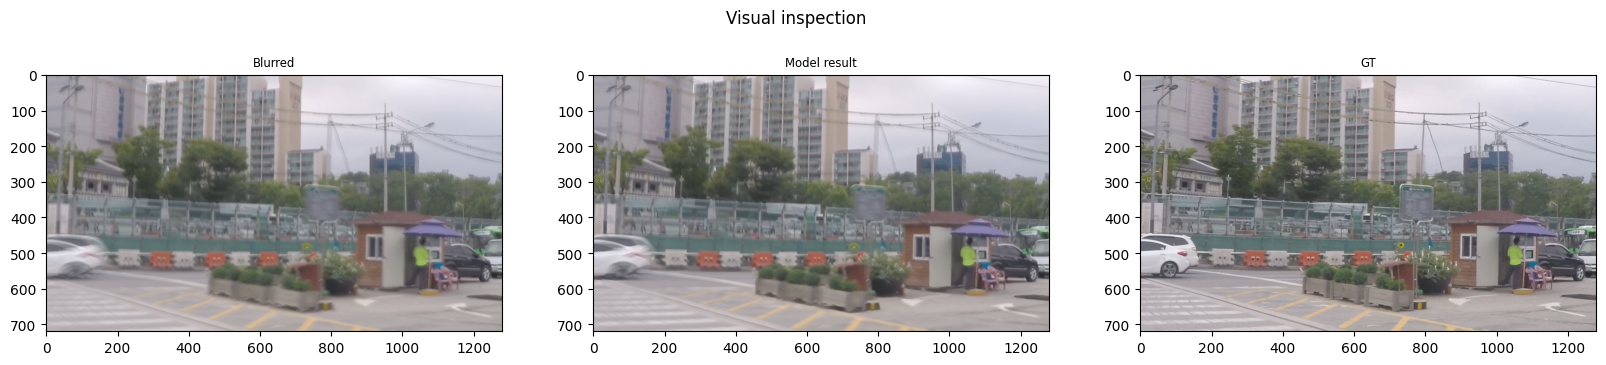

In [39]:
pics = test_dataset[2]
blurred, gt = pics[0], pics[1]
plt.figure(figsize=(20, 4))
plt.suptitle("Visual inspection")
plt.subplot(131)
plt.title("Blurred")
plt.imshow(blurred.permute(1, 2, 0))
plt.subplot(132)
plt.title("Model result")
with torch.no_grad():
    output = model(blurred.unsqueeze(0).to(device)).cpu().squeeze(0).permute(1, 2, 0).numpy()
output = np.clip(output, 0, 1)
plt.imshow(output)
plt.subplot(133)
plt.imshow(gt.permute(1, 2, 0))
plt.title("GT")
plt.show()

## NAFNet
As discussed in the previous section, many networks build upon UNet and change individual blocks.  
[NAFNet](https://arxiv.org/abs/2204.04676) was for a long time a SOTA deblurring approach, even thought it was presented as a baseline. 

The main differences are:
* No regular nonlinearities (no ReLU/GELU/ELU/etc.)
* Simplified channel attention
* LayerNorm instead of BatchNorm
* and many more training tricks taken from transformer papers

In a way this work is similar to [ConvNeXt](https://arxiv.org/abs/2201.03545), where authors also shook off the dust of ResNet and trained a SOTA classification CNN.


**And now you are tasked with implementing NAFNet :)**

### Simple gate block (0.5 points)

<img src="images/gate.png">

Instead of using regular non-linearities NAFNet proposes the use of "Simple Gates" which perform pointwise multiplication of feature maps.

Simple gate layer splits input feature map in 2 part along the channel axis and multiplies them.

You may find [`torch.chunk`](https://pytorch.org/docs/stable/generated/torch.chunk.html) to be useful

In [43]:
class SimpleGate(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        """
        
            Split the input in 2, along the channel axis
            Return multiplication of these 2 parts
        
        """
        chunk1, chunk2 = torch.chunk(x, 2, dim=1)
        return chunk1 * chunk2

In [44]:
block = SimpleGate()
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 32, 256, 256])

### NAFNet up block (0.5 points)

In [45]:
class NAFNetUpBlock(nn.Module):
    def __init__(self, channels):
        """NAFNet upsampling block
        
        Implement and use the following modules:

            conv 1x1 (chan, 2 * chan)
            pixelshuffle(2)
        
        """
        super().__init__()
        self.conv = nn.Conv2d(channels, 2 * channels, kernel_size=1)
        self.pixelshuffle = nn.PixelShuffle(2)

    def forward(self, x):
        x = self.conv(x)
        x = self.pixelshuffle(x)
        return x

In [46]:
block = NAFNetUpBlock(64)
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 32, 512, 512])

### NAFNet down block (0.5 points)

In [47]:
class NAFNetDownBlock(nn.Module):
    def __init__(self, channels):
        """NAFNet downsampling block
        
        Implement and use the following modules:
        
            conv with stride 2, **mind the padding**

        """
        super().__init__()
        self.conv = nn.Conv2d(channels, 2 * channels, kernel_size=1, stride=2)

    def forward(self, x):
        return self.conv(x)

In [48]:
block = NAFNetDownBlock(64)
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 128, 128, 128])

### Simplified channel attention (0.5 points)

Regular channel attention produces weights for each channel of input feature map using 2-layer MLP.  
NAFNet authors propose to remove the small MLP on channels by just pooling and linearly projecting the feature map to get channel weights.

<img src="images/sca.png">

In [49]:
class SCA(nn.Module):
    def __init__(self, in_channels, out_channels):
        """Simplified channel attention module
        
        Implement and use the following modules:
        
            adaptiveavgpool to get 1x1 feature map
            conv 1x1 projection layer
        
        """
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        """
        
            Return only the attention weights
        
        """
        return torch.sigmoid(self.conv(self.pool(x)))

In [50]:
block = SCA(64, 32)
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 32, 1, 1])

### NAFNet block (3 points)

**The final boss of the task**.

The diagram shows the intra-block structure:

<img src="images/nafnet_block.png" width=620>

Note the use of learnable skip-connection scales `beta` and `gamma`, use [`nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)

**Your model must pass the quality assert to get points for this part**

In [51]:
from utils import LayerNorm2d  # use this layernorm

class NAFNetBlock(nn.Module):
    def __init__(self, c, DW_Expand=2, FFN_Expand=2):
        super().__init__()

        dw_channel = c * DW_Expand
        ffn_channel = FFN_Expand * c

        self.beta = nn.Parameter(torch.zeros(1))
        self.gamma = nn.Parameter(torch.zeros(1))

        self.layer_norm1 = LayerNorm2d(c)
        self.conv1 = nn.Conv2d(c, dw_channel, kernel_size=1)
        self.conv2 = nn.Conv2d(dw_channel, dw_channel, kernel_size=3, padding=1)
        self.simple_gate1 = SimpleGate()
        self.sca = SCA(dw_channel // 2, dw_channel // 2)
        self.conv3 = nn.Conv2d(dw_channel // 2, c, kernel_size=1)

        self.layer_norm2 = LayerNorm2d(c)
        self.conv4 = nn.Conv2d(c, ffn_channel, kernel_size=3, padding=1)
        self.simple_gate2 = SimpleGate()
        self.conv5 = nn.Conv2d(ffn_channel // 2, c, kernel_size=3, padding=1)

    def forward(self, inp):
        x = self.layer_norm1(inp)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.simple_gate1(x)
        x = self.conv3(self.sca(x) * x)
        x = self.beta * x
        inp = inp + x
        x = self.layer_norm2(inp)
        x = self.conv4(x)
        x = self.simple_gate2(x)
        x = self.conv5(x)
        x = x * self.gamma
        return x + inp

In [52]:
block = NAFNetBlock(64)
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 64, 256, 256])

### Train NAFNet

In [53]:
from utils import get_scheduler
torch.manual_seed(11)

model = GeneralizedUNet(NAFNetBlock, NAFNetDownBlock, NAFNetUpBlock, enc_blk_nums=[1,2,2,28], dec_blk_nums=[2,2,2,1])
model = model.to(device)

criterion = PSNRLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
use_grad_clip = True
scheduler = get_scheduler(optimizer)

train_model(model, train_dataloader, optimizer, criterion, scheduler, num_epochs=100)

  1%|█▋                                                                                                                                                                       | 1/100 [01:45<2:54:08, 105.54s/it]

Epoch 1, Loss: -25.460575103759766, LR: 0.000975530705321762


  2%|███▍                                                                                                                                                                     | 2/100 [03:34<2:55:14, 107.30s/it]

Epoch 2, Loss: -26.358963012695312, LR: 0.0009045180463377549


  3%|█████                                                                                                                                                                    | 3/100 [05:16<2:49:39, 104.94s/it]

Epoch 3, Loss: -24.25450325012207, LR: 0.0007939132368836219


  4%|██████▊                                                                                                                                                                  | 4/100 [07:04<2:49:50, 106.15s/it]

Epoch 4, Loss: -32.86785125732422, LR: 0.0006545430463377549


  5%|████████▍                                                                                                                                                                | 5/100 [08:49<2:47:29, 105.78s/it]

Epoch 5, Loss: -27.94619369506836, LR: 0.0005000499999999999


  6%|██████████▏                                                                                                                                                              | 6/100 [10:41<2:49:05, 107.93s/it]

Epoch 6, Loss: -26.265838623046875, LR: 0.00034555695366224505


  7%|███████████▊                                                                                                                                                             | 7/100 [12:28<2:46:51, 107.65s/it]

Epoch 7, Loss: -25.384519577026367, LR: 0.0002061867631163781


  8%|█████████████▌                                                                                                                                                           | 8/100 [14:09<2:41:41, 105.45s/it]

Epoch 8, Loss: -26.97538185119629, LR: 9.558195366224507e-05


  9%|███████████████▎                                                                                                                                                          | 9/100 [15:36<2:31:06, 99.64s/it]

Epoch 9, Loss: -28.29059410095215, LR: 2.456929467823799e-05


 10%|████████████████▊                                                                                                                                                       | 10/100 [17:20<2:31:30, 101.00s/it]

Epoch 10, Loss: -26.660533905029297, LR: 1e-07


 11%|██████████████████▌                                                                                                                                                      | 11/100 [18:50<2:25:03, 97.79s/it]

Epoch 11, Loss: -27.016666412353516, LR: 0.000487815352660881


 12%|████████████████████▏                                                                                                                                                   | 12/100 [20:39<2:28:34, 101.30s/it]

Epoch 12, Loss: -24.461883544921875, LR: 0.0004523090231688775


 13%|█████████████████████▊                                                                                                                                                  | 13/100 [22:26<2:29:01, 102.78s/it]

Epoch 13, Loss: -31.06711196899414, LR: 0.000397006618441811


 14%|███████████████████████▌                                                                                                                                                | 14/100 [24:02<2:24:36, 100.89s/it]

Epoch 14, Loss: -23.10089874267578, LR: 0.00032732152316887746


 15%|█████████████████████████▎                                                                                                                                               | 15/100 [25:30<2:17:12, 96.85s/it]

Epoch 15, Loss: -25.3109073638916, LR: 0.000250075


 16%|███████████████████████████                                                                                                                                              | 16/100 [26:58<2:12:11, 94.43s/it]

Epoch 16, Loss: -24.99384880065918, LR: 0.00017282847683112253


 17%|████████████████████████████▋                                                                                                                                            | 17/100 [28:34<2:11:12, 94.85s/it]

Epoch 17, Loss: -26.216230392456055, LR: 0.00010314338155818905


 18%|██████████████████████████████▍                                                                                                                                          | 18/100 [30:09<2:09:26, 94.72s/it]

Epoch 18, Loss: -31.396339416503906, LR: 4.784097683112254e-05


 19%|████████████████████████████████                                                                                                                                         | 19/100 [31:47<2:09:23, 95.84s/it]

Epoch 19, Loss: -25.260204315185547, LR: 1.2334647339118996e-05


 20%|█████████████████████████████████▊                                                                                                                                       | 20/100 [33:29<2:10:18, 97.73s/it]

Epoch 20, Loss: -20.723155975341797, LR: 1e-07


 21%|███████████████████████████████████▍                                                                                                                                     | 21/100 [35:14<2:11:31, 99.89s/it]

Epoch 21, Loss: -26.08572006225586, LR: 0.000487815352660881


 22%|█████████████████████████████████████▏                                                                                                                                   | 22/100 [36:54<2:09:55, 99.94s/it]

Epoch 22, Loss: -24.188068389892578, LR: 0.0004523090231688775


 23%|██████████████████████████████████████▋                                                                                                                                 | 23/100 [38:35<2:08:23, 100.05s/it]

Epoch 23, Loss: -25.281341552734375, LR: 0.000397006618441811


 24%|████████████████████████████████████████▎                                                                                                                               | 24/100 [40:15<2:06:44, 100.06s/it]

Epoch 24, Loss: -22.1957950592041, LR: 0.00032732152316887746


 25%|██████████████████████████████████████████                                                                                                                              | 25/100 [41:57<2:05:44, 100.59s/it]

Epoch 25, Loss: -28.78986358642578, LR: 0.000250075


 26%|███████████████████████████████████████████▋                                                                                                                            | 26/100 [43:56<2:11:01, 106.24s/it]

Epoch 26, Loss: -33.57467269897461, LR: 0.00017282847683112253


 27%|█████████████████████████████████████████████▎                                                                                                                          | 27/100 [45:46<2:10:39, 107.39s/it]

Epoch 27, Loss: -29.058929443359375, LR: 0.00010314338155818905


 28%|███████████████████████████████████████████████                                                                                                                         | 28/100 [47:35<2:09:37, 108.02s/it]

Epoch 28, Loss: -32.59483337402344, LR: 4.784097683112254e-05


 29%|████████████████████████████████████████████████▋                                                                                                                       | 29/100 [49:22<2:07:20, 107.61s/it]

Epoch 29, Loss: -31.39675521850586, LR: 1.2334647339118996e-05


 30%|██████████████████████████████████████████████████▍                                                                                                                     | 30/100 [51:18<2:08:18, 109.97s/it]

Epoch 30, Loss: -25.428375244140625, LR: 1e-07


 31%|████████████████████████████████████████████████████                                                                                                                    | 31/100 [53:06<2:05:58, 109.55s/it]

Epoch 31, Loss: -31.471555709838867, LR: 0.000487815352660881


 32%|█████████████████████████████████████████████████████▊                                                                                                                  | 32/100 [54:55<2:04:04, 109.47s/it]

Epoch 32, Loss: -31.871227264404297, LR: 0.0004523090231688775


 33%|███████████████████████████████████████████████████████▍                                                                                                                | 33/100 [56:39<2:00:06, 107.56s/it]

Epoch 33, Loss: -25.22252655029297, LR: 0.000397006618441811


 34%|█████████████████████████████████████████████████████████                                                                                                               | 34/100 [58:13<1:53:49, 103.48s/it]

Epoch 34, Loss: -28.947952270507812, LR: 0.00032732152316887746


 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 35/100 [59:53<1:51:12, 102.65s/it]

Epoch 35, Loss: -26.80924415588379, LR: 0.000250075


 36%|███████████████████████████████████████████████████████████▊                                                                                                          | 36/100 [1:01:39<1:50:26, 103.54s/it]

Epoch 36, Loss: -28.437297821044922, LR: 0.00017282847683112253


 37%|█████████████████████████████████████████████████████████████▍                                                                                                        | 37/100 [1:03:23<1:48:45, 103.58s/it]

Epoch 37, Loss: -30.63068389892578, LR: 0.00010314338155818905


 38%|███████████████████████████████████████████████████████████████                                                                                                       | 38/100 [1:05:05<1:46:37, 103.18s/it]

Epoch 38, Loss: -23.44609832763672, LR: 4.784097683112254e-05


 39%|████████████████████████████████████████████████████████████████▋                                                                                                     | 39/100 [1:06:52<1:45:58, 104.24s/it]

Epoch 39, Loss: -30.567127227783203, LR: 1.2334647339118996e-05


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 40/100 [1:08:36<1:44:16, 104.27s/it]

Epoch 40, Loss: -26.364845275878906, LR: 1e-07


 41%|████████████████████████████████████████████████████████████████████                                                                                                  | 41/100 [1:10:25<1:44:00, 105.78s/it]

Epoch 41, Loss: -29.05712127685547, LR: 0.000487815352660881


 42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 42/100 [1:12:14<1:43:12, 106.76s/it]

Epoch 42, Loss: -26.856422424316406, LR: 0.0004523090231688775


 43%|███████████████████████████████████████████████████████████████████████▍                                                                                              | 43/100 [1:14:01<1:41:32, 106.89s/it]

Epoch 43, Loss: -29.69356918334961, LR: 0.000397006618441811


 44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 44/100 [1:15:48<1:39:39, 106.78s/it]

Epoch 44, Loss: -25.270782470703125, LR: 0.00032732152316887746


 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                           | 45/100 [1:17:34<1:37:44, 106.63s/it]

Epoch 45, Loss: -31.70352554321289, LR: 0.000250075


 46%|████████████████████████████████████████████████████████████████████████████▎                                                                                         | 46/100 [1:19:24<1:36:55, 107.69s/it]

Epoch 46, Loss: -33.33132553100586, LR: 0.00017282847683112253


 47%|██████████████████████████████████████████████████████████████████████████████                                                                                        | 47/100 [1:21:09<1:34:12, 106.65s/it]

Epoch 47, Loss: -23.852746963500977, LR: 0.00010314338155818905


 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 48/100 [1:23:01<1:33:50, 108.27s/it]

Epoch 48, Loss: -25.888917922973633, LR: 4.784097683112254e-05


 49%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 49/100 [1:24:49<1:32:08, 108.40s/it]

Epoch 49, Loss: -24.0312557220459, LR: 1.2334647339118996e-05


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 50/100 [1:26:41<1:31:11, 109.42s/it]

Epoch 50, Loss: -24.760669708251953, LR: 1e-07


 51%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 51/100 [1:28:34<1:30:09, 110.40s/it]

Epoch 51, Loss: -26.754024505615234, LR: 0.00029272921159652864


 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 52/100 [1:30:21<1:27:33, 109.44s/it]

Epoch 52, Loss: -26.87578582763672, LR: 0.0002714254139013265


 53%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 53/100 [1:32:10<1:25:33, 109.21s/it]

Epoch 53, Loss: -27.234046936035156, LR: 0.00023824397106508657


 54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 54/100 [1:33:56<1:22:57, 108.20s/it]

Epoch 54, Loss: -29.76262092590332, LR: 0.0001964329139013265


 55%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 55/100 [1:35:46<1:21:39, 108.88s/it]

Epoch 55, Loss: -22.314884185791016, LR: 0.000150085


 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 56/100 [1:37:37<1:20:13, 109.39s/it]

Epoch 56, Loss: -25.531429290771484, LR: 0.00010373708609867352


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 57/100 [1:39:33<1:19:54, 111.49s/it]

Epoch 57, Loss: -25.415250778198242, LR: 6.192602893491343e-05


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 58/100 [1:41:22<1:17:30, 110.72s/it]

Epoch 58, Loss: -30.644529342651367, LR: 2.8744586098673522e-05


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 59/100 [1:43:12<1:15:35, 110.63s/it]

Epoch 59, Loss: -28.990367889404297, LR: 7.440788403471397e-06


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 60/100 [1:45:04<1:13:54, 110.87s/it]

Epoch 60, Loss: -28.08877944946289, LR: 1e-07


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 61/100 [1:46:56<1:12:16, 111.18s/it]

Epoch 61, Loss: -25.447490692138672, LR: 0.00029272921159652864


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 62/100 [1:48:46<1:10:20, 111.07s/it]

Epoch 62, Loss: -29.435766220092773, LR: 0.0002714254139013265


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 63/100 [1:50:31<1:07:21, 109.22s/it]

Epoch 63, Loss: -27.452125549316406, LR: 0.00023824397106508657


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 64/100 [1:52:09<1:03:22, 105.62s/it]

Epoch 64, Loss: -29.516389846801758, LR: 0.0001964329139013265


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 65/100 [1:53:55<1:01:45, 105.87s/it]

Epoch 65, Loss: -22.445693969726562, LR: 0.000150085


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 66/100 [1:55:42<1:00:08, 106.14s/it]

Epoch 66, Loss: -29.811416625976562, LR: 0.00010373708609867352


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 67/100 [1:57:27<58:09, 105.73s/it]

Epoch 67, Loss: -28.99503517150879, LR: 6.192602893491343e-05


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 68/100 [1:59:10<56:05, 105.18s/it]

Epoch 68, Loss: -30.924787521362305, LR: 2.8744586098673522e-05


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 69/100 [2:00:55<54:18, 105.10s/it]

Epoch 69, Loss: -35.77712631225586, LR: 7.440788403471397e-06


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 70/100 [2:02:30<50:59, 101.98s/it]

Epoch 70, Loss: -31.072376251220703, LR: 1e-07


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 71/100 [2:04:17<50:03, 103.56s/it]

Epoch 71, Loss: -30.299888610839844, LR: 0.00029272921159652864


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 72/100 [2:06:05<48:50, 104.67s/it]

Epoch 72, Loss: -23.665998458862305, LR: 0.0002714254139013265


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 73/100 [2:07:48<46:52, 104.17s/it]

Epoch 73, Loss: -23.765573501586914, LR: 0.00023824397106508657


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 74/100 [2:09:32<45:10, 104.27s/it]

Epoch 74, Loss: -24.857345581054688, LR: 0.0001964329139013265


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 75/100 [2:11:17<43:34, 104.59s/it]

Epoch 75, Loss: -25.315994262695312, LR: 0.000150085


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 76/100 [2:12:59<41:29, 103.73s/it]

Epoch 76, Loss: -31.664169311523438, LR: 0.00010373708609867352


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 77/100 [2:14:40<39:24, 102.81s/it]

Epoch 77, Loss: -27.939437866210938, LR: 6.192602893491343e-05


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 78/100 [2:16:21<37:31, 102.35s/it]

Epoch 78, Loss: -27.701068878173828, LR: 2.8744586098673522e-05


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 79/100 [2:18:05<35:59, 102.81s/it]

Epoch 79, Loss: -28.64366340637207, LR: 7.440788403471397e-06


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 80/100 [2:19:46<34:05, 102.30s/it]

Epoch 80, Loss: -24.762588500976562, LR: 1e-07


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 81/100 [2:21:29<32:28, 102.56s/it]

Epoch 81, Loss: -25.23725128173828, LR: 0.00029272921159652864


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 82/100 [2:23:16<31:11, 103.96s/it]

Epoch 82, Loss: -28.760957717895508, LR: 0.0002714254139013265


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 83/100 [2:25:02<29:34, 104.37s/it]

Epoch 83, Loss: -25.63245391845703, LR: 0.00023824397106508657


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 84/100 [2:26:47<27:53, 104.57s/it]

Epoch 84, Loss: -28.757247924804688, LR: 0.0001964329139013265


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 85/100 [2:28:36<26:28, 105.91s/it]

Epoch 85, Loss: -28.77493667602539, LR: 0.000150085


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 86/100 [2:30:26<24:59, 107.13s/it]

Epoch 86, Loss: -25.324724197387695, LR: 0.00010373708609867352


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 87/100 [2:32:21<23:43, 109.48s/it]

Epoch 87, Loss: -31.696517944335938, LR: 6.192602893491343e-05


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 88/100 [2:34:09<21:48, 109.01s/it]

Epoch 88, Loss: -27.751773834228516, LR: 2.8744586098673522e-05


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 89/100 [2:35:56<19:54, 108.57s/it]

Epoch 89, Loss: -22.526819229125977, LR: 7.440788403471397e-06


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 90/100 [2:37:43<17:59, 107.98s/it]

Epoch 90, Loss: -23.799636840820312, LR: 1e-07


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 91/100 [2:39:32<16:14, 108.27s/it]

Epoch 91, Loss: -30.520999908447266, LR: 0.00029272921159652864


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 92/100 [2:41:23<14:33, 109.24s/it]

Epoch 92, Loss: -29.37881088256836, LR: 0.0002714254139013265


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 93/100 [2:42:47<11:51, 101.66s/it]

Epoch 93, Loss: -31.575830459594727, LR: 0.00023824397106508657


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 94/100 [2:44:37<10:24, 104.13s/it]

Epoch 94, Loss: -30.32992935180664, LR: 0.0001964329139013265


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 95/100 [2:46:22<08:42, 104.46s/it]

Epoch 95, Loss: -24.950349807739258, LR: 0.000150085


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 96/100 [2:48:08<06:58, 104.71s/it]

Epoch 96, Loss: -31.351938247680664, LR: 0.00010373708609867352


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 97/100 [2:49:51<05:12, 104.22s/it]

Epoch 97, Loss: -26.49300765991211, LR: 6.192602893491343e-05


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 98/100 [2:51:38<03:29, 104.97s/it]

Epoch 98, Loss: -24.410701751708984, LR: 2.8744586098673522e-05


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 99/100 [2:53:23<01:45, 105.13s/it]

Epoch 99, Loss: -26.03179168701172, LR: 7.440788403471397e-06


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:55:10<00:00, 105.10s/it]

Epoch 100, Loss: -21.410503387451172, LR: 1e-07


In [54]:
from utils import test_model
result = test_model(model, device, test_dataloader)
assert result <= 0.002

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 634/634 [02:04<00:00,  5.11it/s]


Mean MSE: 0.0019669591284929076


## Check model results

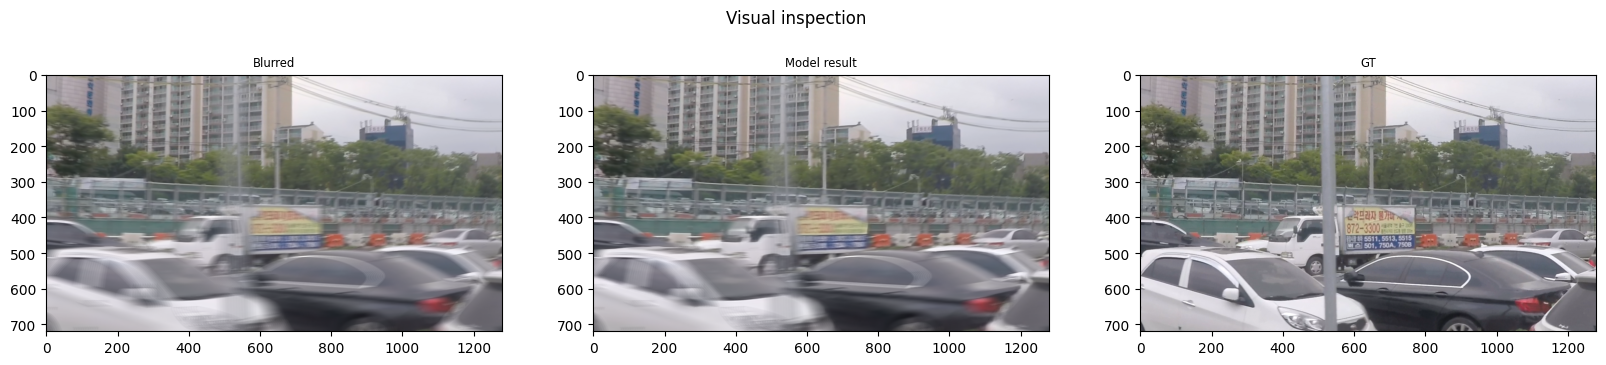

In [56]:
pics = test_dataset[2]
blurred, gt = pics[0], pics[1]
plt.figure(figsize=(20, 4))
plt.suptitle("Visual inspection")
plt.subplot(131)
plt.title("Blurred")
plt.imshow(blurred.permute(1, 2, 0))
plt.subplot(132)
plt.title("Model result")
with torch.no_grad():
    output = model(blurred.unsqueeze(0).to(device)).cpu().squeeze(0).permute(1, 2, 0).numpy()
output = np.clip(output, 0, 1)
plt.imshow(output)
plt.subplot(133)
plt.imshow(gt.permute(1, 2, 0))
plt.title("GT")
plt.show()

# Your thoughts

Please share your thoughts on the task.  
Did you like it, did you hate it?

If so, why?

In general liked the task, but default num_epochs parameters for training piplelines seem to be a bit larger than is nessesary to pass asserts (or assserts are too weak) 